In [10]:
# Core libraries
import numpy as np
from skimage import io, util, morphology, exposure, filters, measure
from scipy.spatial import Voronoi, Delaunay
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# Specific utils
from imageUtils import draw_labels_on_image, colorize_segmentation, normalize_exposure_by_axis
from trimesh import Trimesh
from trimesh.curvature import discrete_gaussian_curvature_measure, \
    discrete_mean_curvature_measure, sphere_ball_intersection
import pyvista as pv

from sklearn import ensemble, linear_model, pipeline
from sklearn import preprocessing, model_selection, decomposition
from sklearn import metrics


# General utils
from os import path
import pickle as pkl
from tqdm import tqdm

def predict_feature(df:pd.DataFrame,
                    regressor,
                    feature2predict,
                    Niter:int=100,):
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      regressor() )
        
        y = df[feature2predict].astype(float)
        X = df.drop(columns=feature2predict).astype(float)
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    

# 0. Load datasets

In [2]:

# Filenames
dirnames = {'R1':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R1',
            'R2':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R2'}

df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Cropped/data_frame_aggregated.pkl'))
    _df['Region'] = name
    _df.index = name + '_' + _df.index.astype(str)
    df.append(_df)
    
df = pd.concat(df)

non_borders = df[~df.Border]

cols2drop = ['Border','Region']
cols2drop += [f for f in non_borders.columns if 'Y' in f or 'X' in f or 'Z' in f]
cols2drop += [f for f in non_borders.columns if 'K10' in f]
cols2drop += [f for f in non_borders.columns if 'Total' in f or 'cell coords' in f]
cols2drop = pd.Index(cols2drop)

dx = 0.3
dz = 0.5
Z_SHIFT = 10
KAPPA = 5 # microns

# for expansion
footprint = morphology.cube(3)


In [11]:
# RandomForest

Niter = 100
feature2predict = 'Mean K10 intensity'

df = non_borders.drop(columns=cols2drop.drop(feature2predict))

predictions,models = predict_feature(df,
                                     ensemble.RandomForestRegressor,
                                     feature2predict,
                                     Niter=Niter)


100%|████████████████████████████████████████████| 100/100 [10:39<00:00,  6.39s/it]


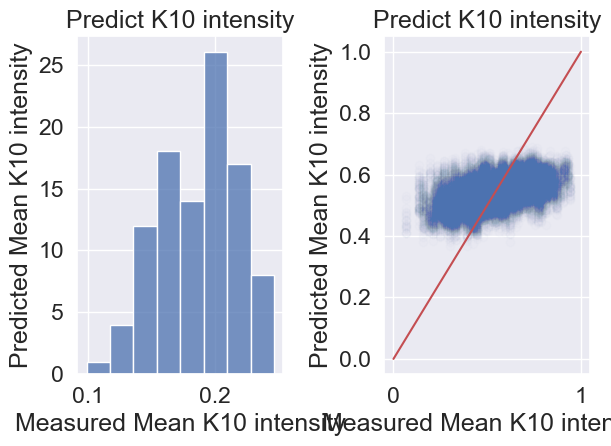

In [18]:
# Calculate the R2 score
r2_score = np.array([metrics.r2_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.subplot(1,2,1)
sb.set(font_scale=1.5)  # crazy big
plt.title('Predict K10 intensity')
sb.histplot(r2_score)
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')

plt.subplot(1,2,2)
plt.title('Predict K10 intensity')
plt.scatter(predictions[0,:].flatten(),predictions[1,:].flatten(),alpha=0.01)
plt.plot([0,1],[0,1],'r')
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')

plt.tight_layout()

In [20]:
m

,steps,"[('standardscaler', ...), ('randomforestregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


Text(0, 0.5, 'Impurity importance')

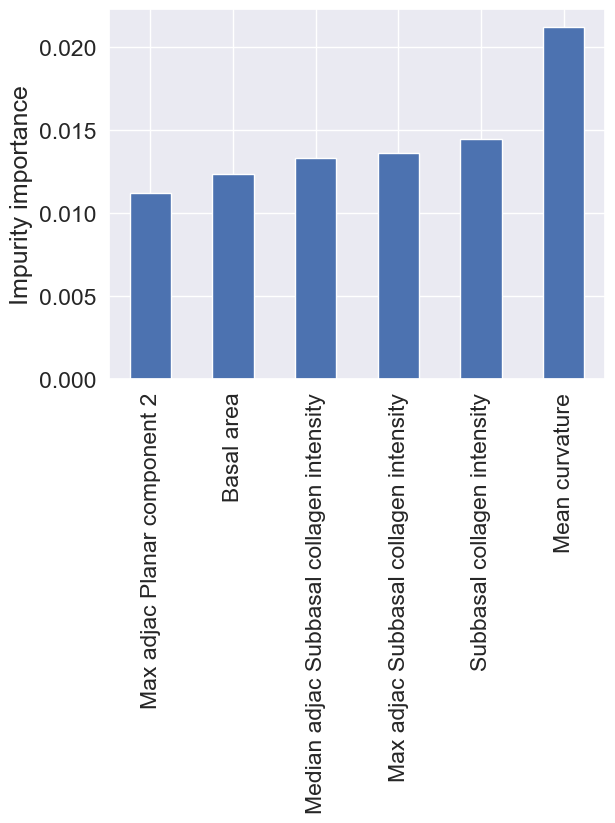

In [24]:
feat_names = df.columns.drop(feature2predict)
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].feature_importances_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(6).plot.bar()

plt.ylabel('Impurity importance')


In [25]:
#%% XGboost

Niter = 100
feature2predict = 'Mean K10 intensity'

df = non_borders.drop(columns=cols2drop.drop(feature2predict))
predictions,models = predict_feature(df,
                                     ensemble.RandomForestRegressor,
                                     feature2predict,
                                     Niter=Niter)


100%|████████████████████████████████████████████| 100/100 [10:39<00:00,  6.40s/it]


In [ ]:
# Calculate the R2 score
avg_confusion = np.array([metrics.r2_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])

sb.set(font_scale=1.5)  # crazy big
plt.title('Predict K10 intensity')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
          cbar_kws={'label':'%'})
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')


In [ ]:
#%% XGboost

Niter = 100
feature2predict = 'Mean K10 intensity'

df = non_borders.drop(columns=cols2drop.drop(feature2predict))

predictions,models = predict_feature(non_borders.drop(columns= cols2drop.drop(feature2predict)),
                                                     linear_model.LinearRegression,
                                                     feature2predict,
                                                     Niter=100)



In [ ]:
# Calculate the R2 score
avg_confusion = np.array([metrics.r2_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])

sb.set(font_scale=1.5)  # crazy big
plt.title('Predict K10 intensity')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
          cbar_kws={'label':'%'})
plt.xlabel(f'Measured {feature2predict}')
plt.ylabel(f'Predicted {feature2predict}')
